# Import packages and defining helper function

In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Defining Experimental Params

In [3]:
show(config)

operator_params
    operator: CenterOcclude
    size: 13
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: posterior
    potential: mse
base_model_params
    model_name: mnist/vae/vanilla


# The experiment 

## Initalisation used

In [4]:
config["operator_params"]["operator"] = "RandomOcclude"
config["operator_params"]["num_measurements"] = 200

## Baseline of 0

In [11]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

## Repeat for different measurments

In [6]:
config["exp_params"]["batch_size"] = 100
config['estimator_params']['lambda'] = 1
config["base_model_params"]["base_model"] = "gan"
config['estimator_params']["initalisation"] = "random"
dm = mnist_dataloader_test(config, path=path)

In [7]:
langevin = []
error_langevin = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    langevin.append(e_x)
    error_langevin.append(std)

100%|██████████| 15/15 [01:19<00:00,  5.32s/it]


In [8]:
config['estimator_params']["initalisation"] = "random"
config['estimator_params']["num_steps_map_initaliser"] = 10
config['estimator_params']["step_size_map_initaliser"] = 0.1
config['estimator_params']['potential'] = "discriminator_weighted"
config["base_model_params"]["base_model"] = "gan"
config['estimator_params']['lambda'] = 1
config['estimator_params']['lambda_score'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["estimator_params"]["num_steps_finetune"] = 10
config["estimator_params"]["num_samples_for_finetune"] = 100

In [9]:
map_est = []
error_map_est = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    ebm.finetune_discrimiantor()
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_est.append(e_x)
    error_map_est.append(std)

100%|██████████| 15/15 [03:28<00:00, 13.88s/it]


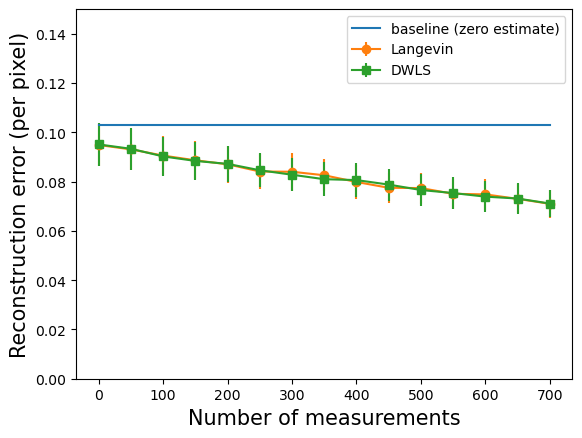

In [10]:
plt.xlabel('Number of measurements', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 750, 50)), [baseline]*15)
plt.errorbar(list(range(0, 750, 50)), langevin, yerr=error_langevin, fmt='-o')
plt.errorbar(list(range(0, 750, 50)), map_est, yerr=error_map_est, fmt='-s')
plt.legend(['baseline (zero estimate)','Langevin', 'DWLS'])
plt.show()

In [11]:
langevin

[tensor(0.0948),
 tensor(0.0931),
 tensor(0.0905),
 tensor(0.0886),
 tensor(0.0870),
 tensor(0.0841),
 tensor(0.0840),
 tensor(0.0826),
 tensor(0.0798),
 tensor(0.0775),
 tensor(0.0774),
 tensor(0.0751),
 tensor(0.0748),
 tensor(0.0730),
 tensor(0.0710)]

In [12]:
map_est

[tensor(0.0951),
 tensor(0.0933),
 tensor(0.0902),
 tensor(0.0884),
 tensor(0.0872),
 tensor(0.0846),
 tensor(0.0828),
 tensor(0.0810),
 tensor(0.0806),
 tensor(0.0788),
 tensor(0.0766),
 tensor(0.0754),
 tensor(0.0739),
 tensor(0.0731),
 tensor(0.0711)]

## Repeat for different burn-in period

In [67]:
config["operator_params"]["operator"] = "RandomOcclude"
config["operator_params"]["num_measurements"] = 200

In [68]:
config["exp_params"]["batch_size"] = 100
config['estimator_params']['lambda'] = 500
config['estimator_params']['potential'] = "mse"
config['estimator_params']["initalisation"] = "random"
config["estimator_params"]["noise_factor"] = 0.5
dm = mnist_dataloader_test(config, path=path)

In [69]:
langevin = []
error_langevin = []
for num in trange(0, 220, 20):
    config["estimator_params"]["burn_in"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    langevin.append(e_x)
    error_langevin.append(std)

100%|██████████| 11/11 [05:36<00:00, 30.57s/it]


In [70]:
config['estimator_params']["initalisation"] = "random"
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['lambda'] = 500
config['estimator_params']['lambda_score'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["estimator_params"]["num_steps_finetune"] = 10
config["estimator_params"]["num_samples_for_finetune"] = 100
config["estimator_params"]["noise_factor"] = 0.5

In [71]:
map_est = []
error_map_est = []
for num in trange(0, 220, 20):
    config["estimator_params"]["burn_in"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    ebm.finetune_discrimiantor()
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_est.append(e_x)
    error_map_est.append(std)

100%|██████████| 11/11 [16:49<00:00, 91.80s/it] 


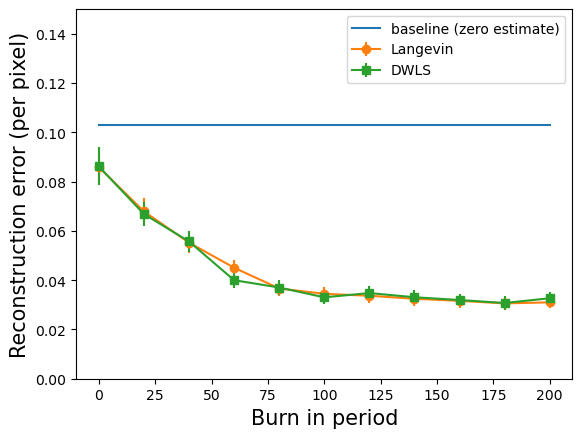

In [76]:
plt.xlabel('Burn in period', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 220, 20)), [baseline]*11)
plt.errorbar(list(range(0, 220, 20)), langevin, yerr=error_langevin, fmt='-o')
plt.errorbar(list(range(0, 220, 20)), map_est, yerr=error_map_est, fmt='-s')
plt.legend(['baseline (zero estimate)','Langevin', 'DWLS'])
plt.show()

In [74]:
print(map_est)

[tensor(0.0862), tensor(0.0668), tensor(0.0557), tensor(0.0400), tensor(0.0370), tensor(0.0330), tensor(0.0348), tensor(0.0331), tensor(0.0319), tensor(0.0307), tensor(0.0327)]


In [75]:
print(langevin)

[tensor(0.0859), tensor(0.0679), tensor(0.0552), tensor(0.0450), tensor(0.0366), tensor(0.0345), tensor(0.0337), tensor(0.0324), tensor(0.0316), tensor(0.0306), tensor(0.0310)]


In [65]:
print(error_langevin)

[tensor(0.0070), tensor(0.0053), tensor(0.0036), tensor(0.0031), tensor(0.0027), tensor(0.0027), tensor(0.0025), tensor(0.0025)]


# Compressed senseing

In [16]:
config["exp_params"]["batch_size"] = 100
dm = mnist_dataloader_test(config, path=path)
config["operator_params"]["operator"] = "CompressedSensing"
config["operator_params"]["num_measurements"] = 200
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["lambda"] = 500
config["estimator_params"]["num_steps_map_initaliser"] = 10
config["estimator_params"]["step_size_map_initaliser"] = 0.1
config['estimator_params']['potential'] = "mse"

In [17]:
langevin = []
error_langevin = []
for num in trange(0, 140, 20):
    config["estimator_params"]["burn_in"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    langevin.append(e_x)
    error_langevin.append(std)

100%|██████████| 7/7 [02:49<00:00, 24.27s/it]


In [62]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['lambda'] = 500
config['estimator_params']['lambda_score'] = 50
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["estimator_params"]["num_steps_finetune"] = 10
config["estimator_params"]["num_samples_for_finetune"] = 100

In [63]:
map_est = []
error_map_est = []
for num in trange(0, 140, 20):
    config["estimator_params"]["burn_in"] = num 
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    ebm.finetune_discrimiantor()
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_est.append(e_x)
    error_map_est.append(std)

100%|██████████| 7/7 [07:29<00:00, 64.17s/it]


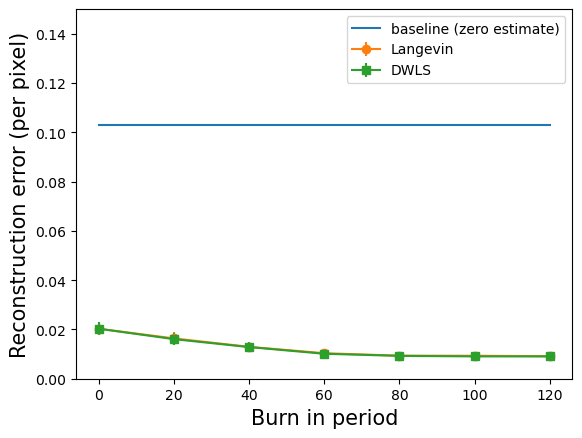

In [64]:
plt.xlabel('Burn in period', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 140, 20)), [baseline]*7)
plt.errorbar(list(range(0, 140, 20)), langevin, yerr=error_langevin, fmt='-o')
plt.errorbar(list(range(0, 140, 20)), map_est, yerr=error_map_est, fmt='-s')
plt.legend(['baseline (zero estimate)','Langevin', 'DWLS'])
plt.show()

In [67]:
print(map_est)

[tensor(0.0203), tensor(0.0161), tensor(0.0128), tensor(0.0101), tensor(0.0093), tensor(0.0091), tensor(0.0091)]


In [68]:
print(langevin)

[tensor(0.0203), tensor(0.0164), tensor(0.0129), tensor(0.0104), tensor(0.0094), tensor(0.0093), tensor(0.0091)]
